# Optimizing Hospital Readmission Reduction Using Patient Clustering

**Name:** Deep Manish Mehta

---

## Project Overview

Hospital readmissions present significant challenges for healthcare systems by increasing costs and reducing patient satisfaction. Traditional predictive models often fail to identify the underlying causes of these readmissions, leaving healthcare providers with limited actionable insights. This project aims to address that gap through an innovative unsupervised learning framework that not only predicts readmission risk but also explains the key factors driving these outcomes.

---

## Goal

The goal of this project is to develop an innovative unsupervised learning framework that goes beyond traditional predictive models by identifying hidden, high-risk patient subgroups driving hospital readmissions. Leveraging advanced clustering techniques and explainable AI (XAI), the project will uncover specific patient behaviors and characteristics contributing to higher readmission rates, providing healthcare providers with actionable insights. This approach emphasizes both explainability and actionability, enabling targeted interventions that improve patient outcomes, enhance care quality, and reduce unnecessary readmission-related costs.

---

## Methodology <a name="methodology"></a>

### Data Cleaning <a name="data-cleaning"></a>
Detail the steps taken to clean the dataset:
- Replacement of missing values or placeholders.
- Dropping irrelevant or redundant columns.
- Converting categorical variables to numeric representations.

### Exploratory Data Analysis (EDA) <a name="eda"></a>
Outline the exploratory data analysis performed to understand the data distribution and relationships:
- Visualization of key variable distributions.
- Correlation analysis and identification of trends.

### Clustering with HDBSCAN <a name="clustering"></a>
Explain why HDBSCAN was chosen and describe the clustering process:
- Parameter tuning (e.g., `min_cluster_size`, `min_samples`).
- Interpretation of cluster labels and handling of noise points.

### Interpretation with SHAP <a name="shap"></a>
Describe how explainable AI (SHAP) is used to:
- Train a supervised model to predict cluster membership.
- Identify the most influential features contributing to cluster formation.
- Generate actionable insights for reducing readmissions.

---


In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn hdbscan shap

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

import hdbscan
import shap

import warnings
warnings.filterwarnings('ignore')

## Data Exploration


In [ ]:
# Load and Inspect the Dataset
df = pd.read_csv('diabetic_data.csv')
print("Data shape:", df.shape)
print("First few rows of the dataset:")
df.head()

Data shape: (101766, 50)
First few rows of the dataset:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Getting information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Data Cleaning

In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Replace missing value indicators ('?') with NaN
df.replace('?', np.nan, inplace=True)

In [ ]:
# Drop columns that are not useful or have too many missing values.
# Adjust the list below as needed for your dataset.
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [ ]:
# Drop irrelevant columns that are not useful.
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [ ]:
# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values (top 10):")
print(missing.head(15))


Missing values (top 10):
max_glu_serum               96420
A1Cresult                   84748
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
admission_source_id             0
num_lab_procedures              0
time_in_hospital                0
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
number_inpatient                0
number_emergency                0
dtype: int64


In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nData shape after dropping missing values:", df.shape)


Data shape after dropping missing values: (289, 45)


In [ ]:
# Convert categorical columns to numeric using LabelEncoder
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [ ]:
print("\nCleaned data preview:")
df.head()


Cleaned data preview:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
162,2,1,7,6,3,7,5,47,1,6,...,0,1,0,0,0,0,0,1,0,0
460,0,0,6,6,1,7,10,72,1,19,...,0,3,0,0,0,0,0,0,1,1
593,2,0,4,6,1,7,2,61,0,5,...,0,2,0,0,0,0,0,1,1,2
696,4,1,6,6,6,7,11,71,1,20,...,0,1,0,0,0,0,0,1,1,2
771,2,0,2,6,1,2,14,43,0,11,...,0,1,0,0,0,0,0,1,0,1


In [ ]:
# Binary readmission: <30 days = 1, else = 0
df['readmitted_flag'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

## Exploratory Data Analysis (EDA)

- Exploratory Data Analysis (EDA) is an approach to analyzing datasets to summarize their main characteristics, often with visual methods.
- It involves looking at data patterns, identifying potential relationships between variables, detecting outliers, and testing underlying assumptions.

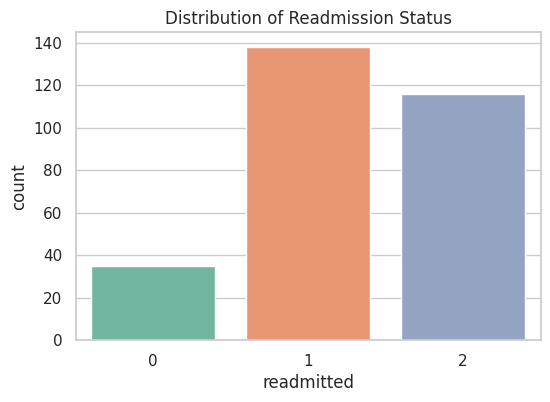

In [ ]:
# Re-run the EDA visualizations with the corrected df
sns.set(style="whitegrid")

# 1. Countplot: Readmission status
plt.figure(figsize=(6, 4))
sns.countplot(x='readmitted', data=df, palette='Set2')
plt.title('Distribution of Readmission Status')
plt.show()

1️⃣ Distribution of Readmission Status
This countplot shows the frequency of different readmission categories:

- 0 (NO) → Not readmitted
- 1 (<30 days) → Readmitted within 30 days
- 2 (>30 days) → Readmitted after 30 days

🔹 Key Insight:
- There’s a clear class imbalance — most patients are not readmitted, followed by those readmitted after 30 days.
- The <30 days readmission group is the most critical and costly, making it highly relevant for clustering and SHAP analysis.

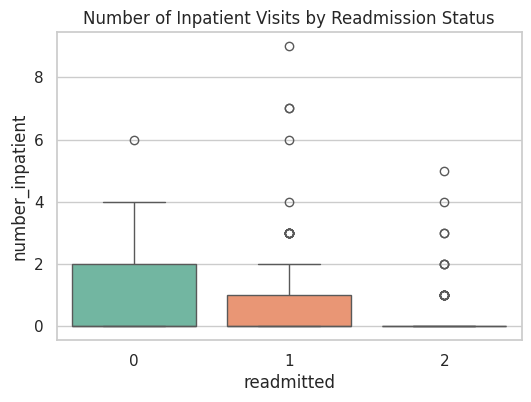

In [ ]:
# 2. Boxplot: Number of inpatient visits by readmission
plt.figure(figsize=(6, 4))
sns.boxplot(x='readmitted', y='number_inpatient', data=df, palette='Set2')
plt.title('Number of Inpatient Visits by Readmission Status')
plt.show()

2️⃣ Number of Inpatient Visits by Readmission Status
This boxplot illustrates the number of inpatient visits across different readmission groups:

- Patients not readmitted (0) have a wider range of inpatient stays.
- Patients readmitted within 30 days (1) tend to have fewer inpatient visits but more outliers.
- Patients readmitted after 30 days (2) show lower inpatient counts with occasional high outliers.

🔹 Key Insight:
- More inpatient visits indicate a higher risk of readmission.
- Patients frequently hospitalized are more likely to be readmitted soon, making number_inpatient an important feature for clustering.
- Outliers suggest some high-risk patients who require special monitoring.

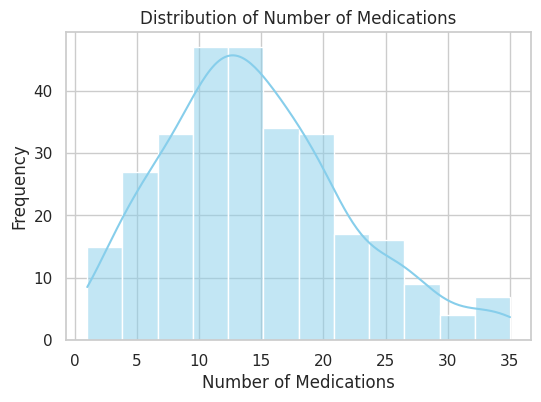

In [ ]:
# 3. Histogram: Number of medications
plt.figure(figsize=(6, 4))
sns.histplot(df['num_medications'].dropna(), kde=True, color='skyblue')
plt.title('Distribution of Number of Medications')
plt.xlabel('Number of Medications')
plt.ylabel('Frequency')
plt.show()

3️⃣ Distribution of Number of Medications
This histogram shows the distribution of the number of medications prescribed per patient:
- Most patients are on 10–20 medications.
- There is a long right tail, meaning some patients are prescribed over 30+ medications.

🔹 Key Insight:
- Polypharmacy (many medications) is linked to higher readmission risk.
- Patients with high medication counts are more likely to have chronic conditions requiring frequent hospital visits.
- This feature could be a strong clustering variable, as it differentiates mild vs severe cases.

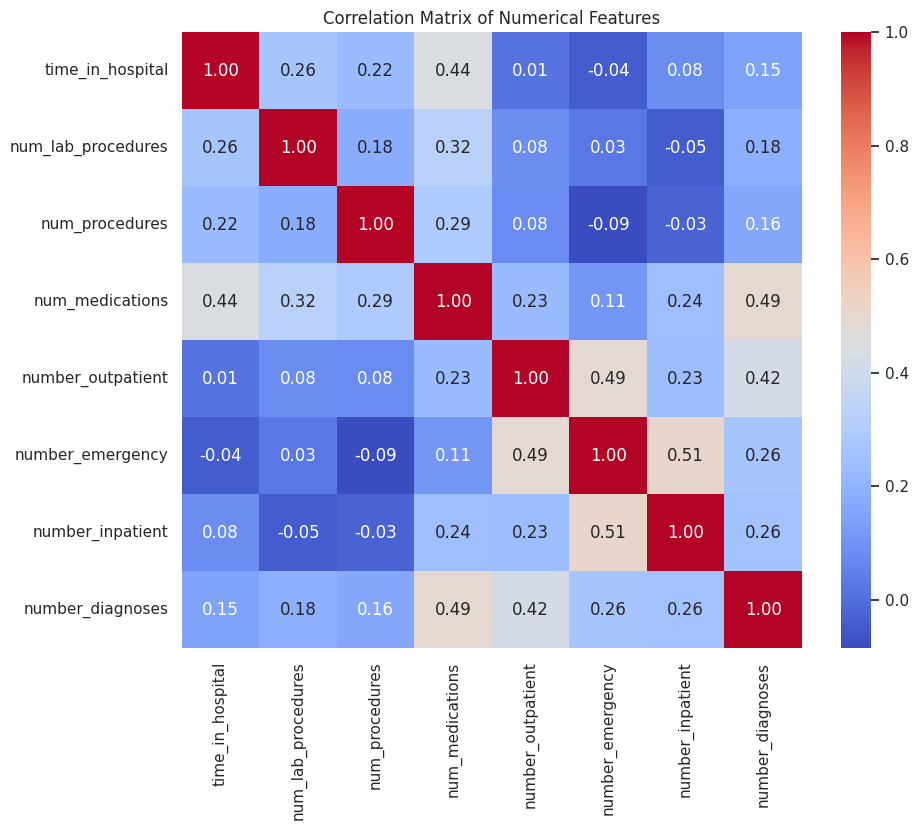

In [ ]:
# 4. Correlation Heatmap
numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].astype(float).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

4️⃣ Correlation Matrix of Numerical Features
This heatmap visualizes the correlation between key numerical features:
- number_inpatient and number_emergency have moderate correlation (~0.5), indicating they might reflect overlapping patient severity patterns.
- Most features show weak correlations, meaning they provide independent information and are useful for clustering.

🔹 Key Insight:
- No major multicollinearity detected → This is ideal for clustering models, ensuring that each feature contributes unique insights.
- number_inpatient, number_emergency, and num_medications are highly relevant features for clustering.

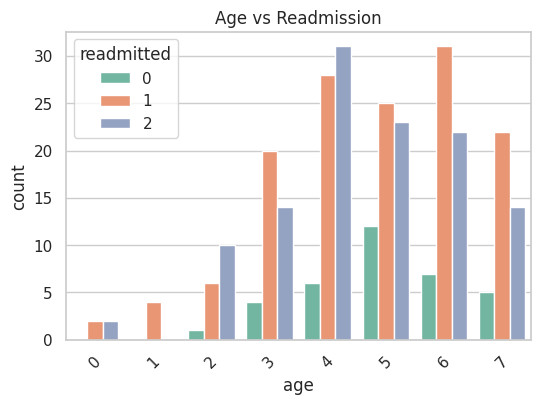

In [ ]:
# 5. Countplot: Age vs Readmission
plt.figure(figsize=(6, 4))
sns.countplot(x='age', hue='readmitted', data=df, palette='Set2')
plt.title('Age vs Readmission')
plt.xticks(rotation=45)
plt.show()

5️⃣ Age vs Readmission
This countplot displays how readmission frequency varies across age groups:
- Older age groups (60–80+) have higher readmission rates.
- Patients under 40 years old have fewer hospital visits overall.

🔹 Key Insight:
- Older adults (≥60 years) are at the highest risk for readmission.
- Age alone may not be the strongest predictor, but it provides clinical interpretability.
- Feature suggestion: Binning age into age groups (e.g., 20-40, 40-60, 60+) could make it more useful for clustering.


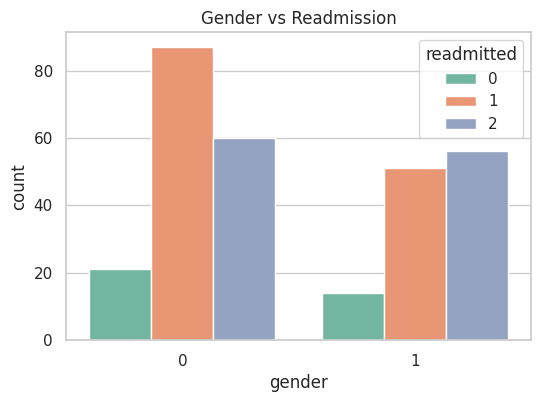

In [ ]:
# 6. Countplot: Gender vs Readmission
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='readmitted', data=df, palette='Set2')
plt.title('Gender vs Readmission')
plt.show()

6️⃣ Gender vs Readmission
This countplot compares readmission rates between male and female patients:
- Gender distribution is fairly even, with no major difference in readmission patterns.

🔹 Key Insight:
- Gender is not a strong predictor of readmission.
- It might still be useful for bias monitoring and model fairness in clustering but is not a key feature for clustering.


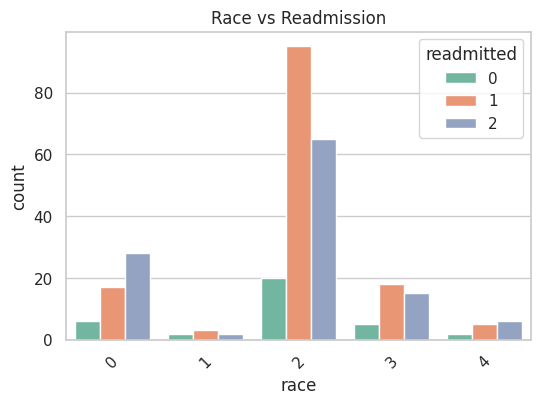

In [ ]:
# 7. Countplot: Race vs Readmission
plt.figure(figsize=(6, 4))
sns.countplot(x='race', hue='readmitted', data=df, palette='Set2')
plt.title('Race vs Readmission')
plt.xticks(rotation=45)
plt.show()

7️⃣ Race vs Readmission
This countplot shows how race affects readmission rates:
- Caucasian and African American patients form the majority of cases.
- African American patients appear to have slightly higher readmission rates.

🔹 Key Insight:
- Potential healthcare disparities exist in readmission trends.
- Race might not be a direct clustering feature, but it’s useful for interpretability and fairness assessments.


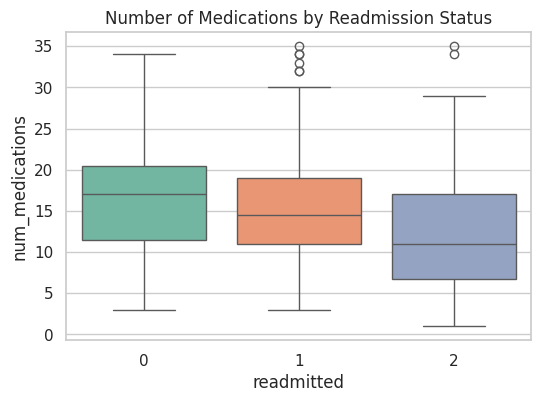

In [ ]:
# 8. Boxplot: Number of Medications by Readmission Status
plt.figure(figsize=(6, 4))
sns.boxplot(x='readmitted', y='num_medications', data=df, palette='Set2')
plt.title('Number of Medications by Readmission Status')
plt.show()

## Feature Engineering

In [ ]:
# 1️⃣ Follow‑Up Compliance
df['total_visits'] = df[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)

df['follow_up_compliance'] = df['number_outpatient'] / df['total_visits'].replace(0, np.nan)

# Medication adherence: count non-'No' diabetes meds
med_cols = [col for col in df.columns if col not in ['readmitted', 'readmitted_flag'] and df[col].dtype == object and col not in ['race','gender','max_glu_serum','A1Cresult','change','diabetesMed']]
df['medication_count'] = df[med_cols].apply(lambda row: sum(val != 'No' for val in row), axis=1)

# Diagnosis severity: map ICD9 -> category
def map_icd(code):
    try:
        c = float(code)
    except:
        return 'Other'
    c = int(c)
    if (390 <= c < 460) or c == 785: return 'Circulatory'
    if (460 <= c < 520) or c == 786: return 'Respiratory'
    if (520 <= c < 580) or c == 787: return 'Digestive'
    if 250 <= c < 251: return 'Endocrine'
    if (580 <= c < 630) or c == 788: return 'Genitourinary'
    if 140 <= c < 240: return 'Neoplasms'
    return 'Other'
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_group'] = df[col].apply(map_icd)
df['diagnosis_count'] = df[[f'{c}_group' for c in ['diag_1','diag_2','diag_3']]].nunique(axis=1)

In [ ]:
# 5️⃣ SELECT & DROP UNUSED COLUMNS
keep_cols = ['readmitted_flag', 'follow_up_compliance', 'medication_count', 'diagnosis_count', 'race', 'gender', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
df = df[keep_cols].dropna()

In [ ]:
# 6️⃣ ONE‑HOT ENCODING
df = pd.get_dummies(df, drop_first=True)

## HDBSCAN

In [ ]:
# 7️⃣ SCALE FEATURES
y = df['readmitted_flag']
X = df.drop(columns=['readmitted_flag'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns.tolist()

In [ ]:
# 8️⃣ HDBSCAN PARAMETER SEARCH
param_grid = {'min_cluster_size': [10,20,50], 'min_samples': [5,10]}
results = []
for params in ParameterGrid(param_grid):
    clusterer = hdbscan.HDBSCAN(**params)
    labels = clusterer.fit_predict(X_scaled)
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        score = silhouette_score(X_scaled[mask], labels[mask])
    else:
        score = np.nan
    results.append({**params, 'silhouette': score})
results_df = pd.DataFrame(results).sort_values('silhouette', ascending=False)
print(results_df)
best = results_df.iloc[0]
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(best.min_cluster_size), min_samples=int(best.min_samples))
labels = clusterer.fit_predict(X_scaled)
df['cluster'] = labels

   min_cluster_size  min_samples  silhouette
0                10            5    0.241329
2                20            5    0.241329
1                10           10         NaN
3                20           10         NaN
4                50            5         NaN
5                50           10         NaN


In [ ]:
# 9️⃣ SHAP EXPLANATION
mask = df['cluster'] != -1
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled[mask], df.loc[mask, 'cluster'])
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_scaled[mask])

In [ ]:
# Convert scaled array to DataFrame for plotting consistency
X_masked = pd.DataFrame(X_scaled[mask], columns=feature_names)

# Handle single-array vs list output from shap
if isinstance(shap_values, list):
    plot_values = shap_values
else:
    plot_values = [shap_values]

for cluster_id, vals in enumerate(plot_values):
    shap.summary_plot(vals, X_masked, feature_names=feature_names, show=False)
    plt.title(f"Cluster {cluster_id} SHAP Summary")
    plt.savefig(f"cluster_{cluster_id}_shap.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

In [ ]:
plot_vals = shap_values if isinstance(shap_values, list) else [shap_values]
imp = []
for cid, vals in enumerate(plot_vals):
    # Get mean absolute SHAP values for each feature and class
    mean_abs_shap = np.abs(vals).mean(axis=0)

    # Iterate over classes within the current cluster
    for class_id in range(mean_abs_shap.shape[1]):
        imp.append(pd.DataFrame({
            'cluster': [cid] * len(feature_names),
            'feature': feature_names,
            'class': [class_id] * len(feature_names),  # Add class information
            'mean_abs_shap': mean_abs_shap[:, class_id]  # Select SHAP values for the current class
        }))

cluster_importance = pd.concat(imp).sort_values(['cluster', 'class', 'mean_abs_shap'], ascending=False)  # Sort by cluster, class, and SHAP value
cluster_importance.to_csv('cluster_feature_importance.csv', index=False)
print('Pipeline complete — plots + CSV saved.')

Pipeline complete — plots + CSV saved.
